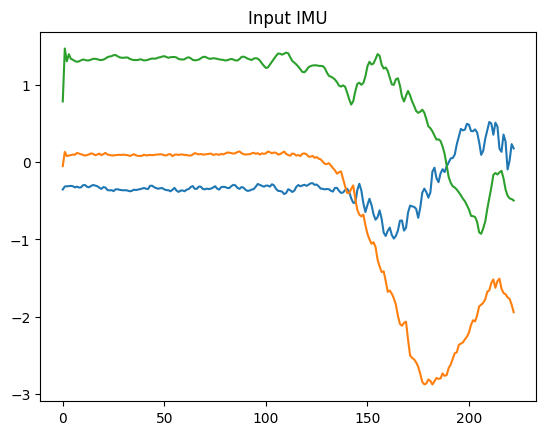

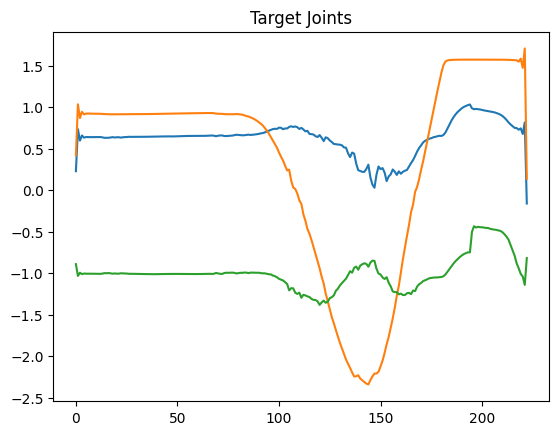

c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch [1/1000], Train Loss: 0.9932, Val Loss: 1.0235
Epoch [2/1000], Train Loss: 0.8675, Val Loss: 0.8845
Epoch [3/1000], Train Loss: 0.6442, Val Loss: 0.7698
Epoch [4/1000], Train Loss: 0.5176, Val Loss: 0.7190
Epoch [5/1000], Train Loss: 0.4885, Val Loss: 0.6885
Epoch [6/1000], Train Loss: 0.5009, Val Loss: 0.6835
Epoch [7/1000], Train Loss: 0.4966, Val Loss: 0.6960
Epoch [8/1000], Train Loss: 0.4815, Val Loss: 0.6985
Epoch [9/1000], Train Loss: 0.4806, Val Loss: 0.6860
Epoch [10/1000], Train Loss: 0.4835, Val Loss: 0.6922
Epoch [11/1000], Train Loss: 0.4811, Val Loss: 0.7003
Epoch [12/1000], Train Loss: 0.4911, Val Loss: 0.7056
Epoch [13/1000], Train Loss: 0.4787, Val Loss: 0.7004
Epoch [14/1000], Train Loss: 0.4897, Val Loss: 0.6948
Epoch [15/1000], Train Loss: 0.4933, Val Loss: 0.6893
Epoch [16/1000], Train Loss: 0.4824, Val Loss: 0.6816
Epoch [17/1000], Train Loss: 0.4780, Val Loss: 0.6818
Epoch [18/1000], Train Loss: 0.4750, Val Loss: 0.6849
Epoch [19/1000], Train Loss: 0.4888, 

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torchaudio.transforms as T
import numpy as np
from scipy.io import wavfile
from torch.utils.data import Dataset, DataLoader, random_split
import os
import matplotlib.pyplot as plt

class AudioDataset(Dataset):
    def __init__(self, input_wav, target_wav, sample_rate=16000):
        if not os.path.exists(input_wav) or not os.path.exists(target_wav):
            raise FileNotFoundError(f"Input file {input_wav} or target file {target_wav} not found.")

        try:
            self.input_sr, self.input_wav = wavfile.read(input_wav)
            self.target_sr, self.target_wav = wavfile.read(target_wav)
        except Exception as e:
            raise RuntimeError(f"Error loading wav files: {e}")

        self.input_wav = torch.tensor(self.input_wav, dtype=torch.float32)
        self.target_wav = torch.tensor(self.target_wav, dtype=torch.float32)
        
        if self.input_sr != sample_rate:
            self.input_wav = T.Resample(self.input_sr, sample_rate)(self.input_wav.T).T
        if self.target_sr != sample_rate:
            self.target_wav = T.Resample(self.target_sr, sample_rate)(self.target_wav.T).T

        self.length = min(len(self.input_wav), len(self.target_wav))
        self.input_wav = self.input_wav[:self.length]
        self.target_wav = self.target_wav[:self.length]

        # Normalize data
        self.input_wav = (self.input_wav - self.input_wav.mean()) / self.input_wav.std()
        self.target_wav = (self.target_wav - self.target_wav.mean()) / self.target_wav.std()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.input_wav[idx], self.target_wav[idx]

def plot_predictions(inputs, targets, predictions, num_channels=3):
    fig, axs = plt.subplots(num_channels, 1, figsize=(10, 8))

    for i in range(num_channels):
        axs[i].plot(targets[:, i], label='Ground Truth')
        axs[i].plot(predictions[:, i], label='Prediction')
        axs[i].set_title(f'Target vs Prediction Channel {i + 1}')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

class DeepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(1).to(device)  # Ensure 3D tensor
            targets = targets.unsqueeze(1).to(device)  # Ensure 3D tensor
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validate
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.unsqueeze(1).to(device)  # Ensure 3D tensor
                targets = targets.unsqueeze(1).to(device)  # Ensure 3D tensor

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, data_loader, device):
    model.eval()
    all_inputs, all_targets, all_predictions = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.unsqueeze(1).to(device)  # Ensure 3D tensor
            targets = targets.unsqueeze(1).to(device)  # Ensure 3D tensor

            outputs = model(inputs)
            
            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())

    all_inputs = np.concatenate(all_inputs)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)

    return all_inputs, all_targets, all_predictions

def main(input_wav, target_wav, sample_rate=16000, hidden_size=256, num_layers=6, num_epochs=1000, batch_size=64, learning_rate=0.002):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset = AudioDataset(input_wav, target_wav, sample_rate)
    
    input_wav = dataset.input_wav
    target_wav = dataset.target_wav

    plt.plot(input_wav)
    plt.title('Input IMU')
    plt.show()
    plt.plot(target_wav)
    plt.title('Target Joints')
    plt.show()
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Update input_size and output_size to match the number of features
    model = DeepLSTMModel(input_size=3, hidden_size=hidden_size, num_layers=num_layers, output_size=3).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)
    
    # Plot training and validation loss history
    plot_loss(train_losses, val_losses)
    
    # Evaluate model on validation and test sets and plot predictions
    val_inputs, val_targets, val_predictions = evaluate_model(model, val_loader, device)
    plot_predictions(val_inputs.squeeze(), val_targets.squeeze(), val_predictions.squeeze(), num_channels=3)

    test_inputs, test_targets, test_predictions = evaluate_model(model, test_loader, device)
    plot_predictions(test_inputs.squeeze(), test_targets.squeeze(), test_predictions.squeeze(), num_channels=3)



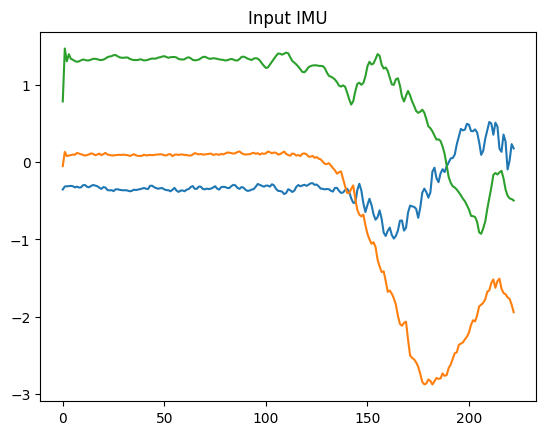

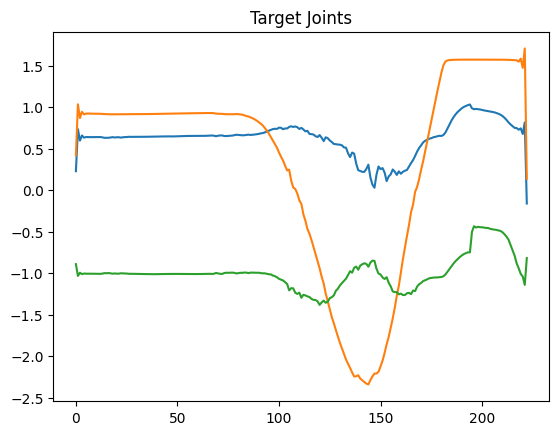

c:\Users\saile\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch [1/1000], Train Loss: 0.9352, Val Loss: 0.8784
Epoch [2/1000], Train Loss: 0.8039, Val Loss: 0.7214
Epoch [3/1000], Train Loss: 0.5932, Val Loss: 0.5852
Epoch [4/1000], Train Loss: 0.5441, Val Loss: 0.5446
Epoch [5/1000], Train Loss: 0.4641, Val Loss: 0.5520
Epoch [6/1000], Train Loss: 0.5025, Val Loss: 0.5522
Epoch [7/1000], Train Loss: 0.4844, Val Loss: 0.5344
Epoch [8/1000], Train Loss: 0.4841, Val Loss: 0.5389
Epoch [9/1000], Train Loss: 0.4686, Val Loss: 0.5481
Epoch [10/1000], Train Loss: 0.4756, Val Loss: 0.5387
Epoch [11/1000], Train Loss: 0.4632, Val Loss: 0.5355
Epoch [12/1000], Train Loss: 0.4653, Val Loss: 0.5367
Epoch [13/1000], Train Loss: 0.4581, Val Loss: 0.5354
Epoch [14/1000], Train Loss: 0.4700, Val Loss: 0.5366
Epoch [15/1000], Train Loss: 0.4678, Val Loss: 0.5385
Epoch [16/1000], Train Loss: 0.4643, Val Loss: 0.5353
Epoch [17/1000], Train Loss: 0.4630, Val Loss: 0.5326
Epoch [18/1000], Train Loss: 0.4682, Val Loss: 0.5320
Epoch [19/1000], Train Loss: 0.4618, 

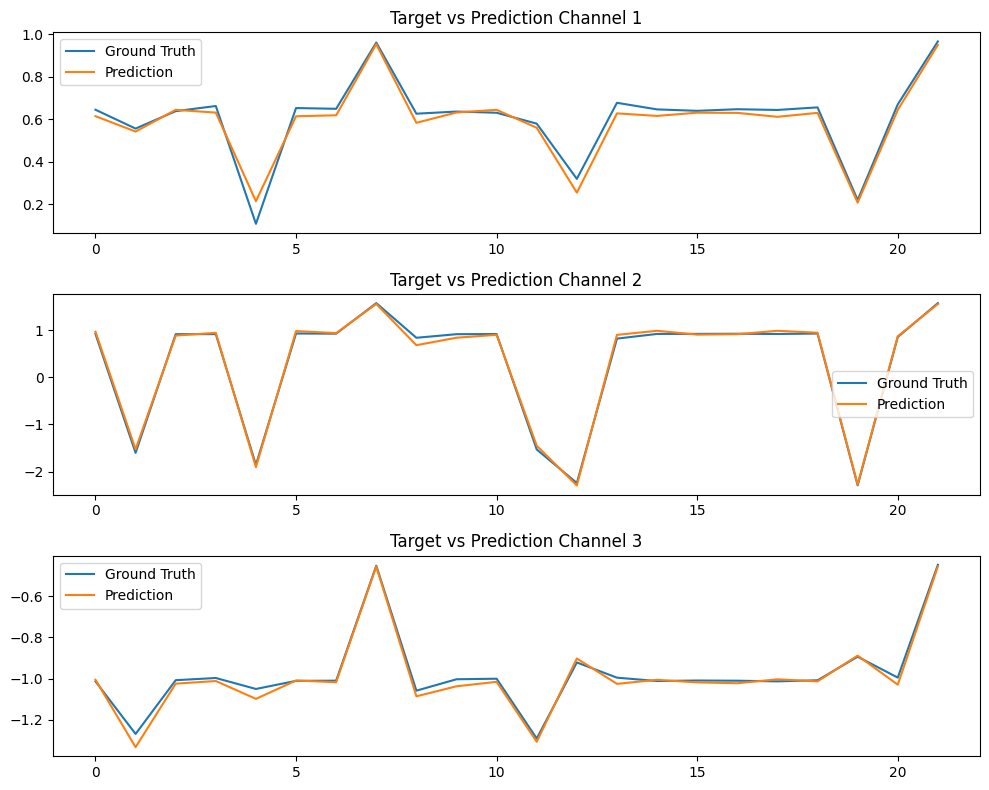

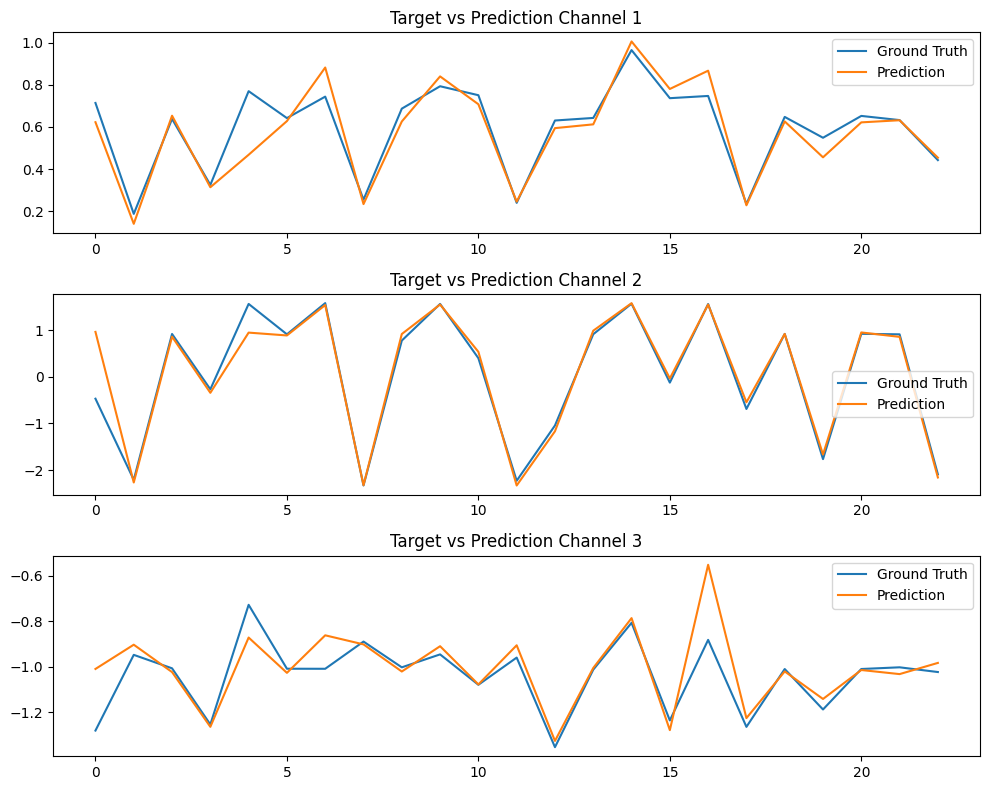

In [ ]:
input_wav = '../../datacollection/imu_data.wav'
target_wav = '../../datacollection/joint_data.wav'
main(input_wav, target_wav)

In [ ]:
#plot loss curve

plt.plot(losses)
plt.title('Loss Curve')
plt.xlabel('Epoch')

NameError: name 'losses' is not defined